Instructions for build are here: https://github.com/eho-tacc/episimlab/issues/26

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
import pandas as pd
import numpy as np
import xarray as xr
from xarray.ufuncs import isnan
import xsimlab as xs
from episimlab.partition import partition
from episimlab.setup.coords import InitDefaultCoords
import multiprocessing as mp
from datetime import datetime
from scripts.DemoATX import main
import matplotlib.pyplot as plt


# Run `episimlab` with Austin-Round Rock MSA parameters

There are two levels at which parameters are exposed to the user:

- configuration YAML file specifies all SEIR model parameters **except** beta (transmission probability)
- command line args to the model runner are used to specify initial model state and simulation duration

In [2]:
cli_pars = {
    'n_cores': 2,
    'config_fp': '/Users/kpierce/episimlab/scripts/DemoATX.yaml',
    'travel_fp': '/Users/kpierce/episimlab/data/full_first_wave_2020_travel.csv',
    'contacts_fp': '/Users/kpierce/episimlab/data/polymod_contacts.csv',
    'census_counts_csv': '/Users/kpierce/episimlab/data/data_lccf/census_pop1_rows1.csv',
    'beta': 0.035,
    'initial_ia': 10,
    'start_date': '3/11/2020',
    'end_date': '9/21/2020',
    'initial_vertex': 78712
}

In [3]:
#demo_result = main(**cli_pars)

Exposing the parameters after the run isn't possible right now -- `main()` returns only the results object, not the model object. `main()` can be edited to return both in the future.

Saving to `zarr` format because of error with `xr.to_netcdf()` (bug in xarray; traceback includes link to open github issue). Note that xarray can only read `zarr` files written by xarray.

In [4]:
#demo_result.to_zarr('/Users/kpierce/episimlab/results/DemoATX_78712_start.zarr')
#demo_result.to_zarr('/Users/kpierce/episimlab/results/DemoATX_78712_start_with_incidence.zarr')

In [5]:
demo_result = xr.open_zarr('/Users/kpierce/episimlab/results/DemoATX_78712_start_with_incidence.zarr')

`apply_counts_delta__counts` is the name of the attribute containing the population sizes (counts) for each timestep, compartment, ZCTA, age group, and risk group combination.

In [6]:
data_arr = demo_result['apply_counts_delta__counts']

Plot the cumulative incidence compartments

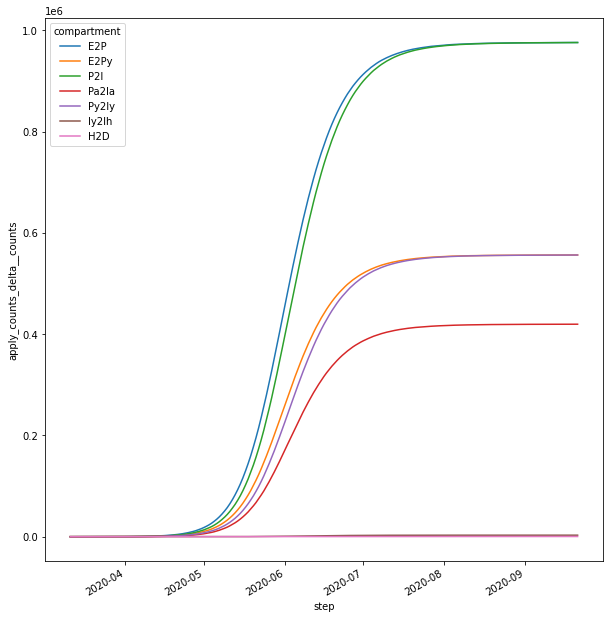

In [7]:
demo_arr_incidence = data_arr.sel({'compartment': ['E2P', 'E2Py', 'P2I', 'Pa2Ia',
                            'Py2Iy', 'Iy2Ih', 'H2D']}).sum(dim=['risk_group', 'age_group', 'vertex'])

fig, ax = plt.subplots(1, 1, figsize=(10,10))
demo_arr_incidence.plot(
    hue='compartment',
    x='step'
)
plt.show()

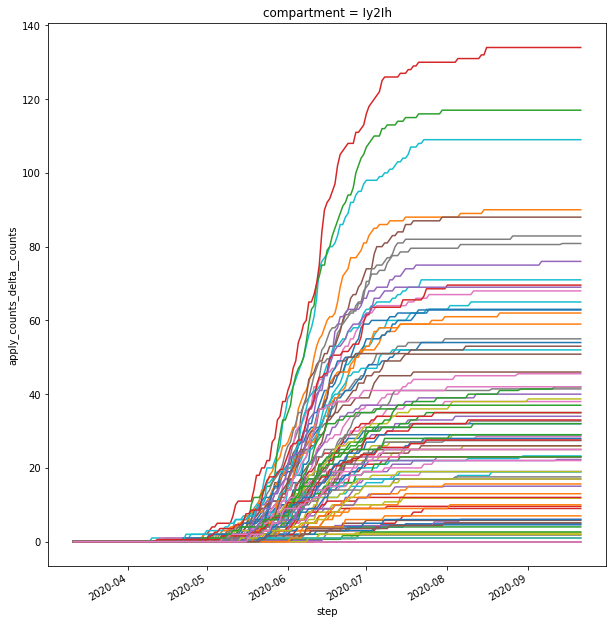

In [8]:
demo_arr_all_inf_inc = data_arr.sel({'compartment': 'Iy2Ih'}).sum(dim=['risk_group', 'age_group'])

fig, ax = plt.subplots(1, 1, figsize=(10,10))
demo_arr_all_inf_inc.plot(
    hue='vertex',
    x='step'
)
ax.get_legend().remove()
plt.show()

Use `xr.sel()` to extract the hospitalized ("Ih") compartment, and sum across risk and age groups.

In [9]:
demo_arr_all_risk = data_arr.sel({'compartment': 'Ih'}).sum(dim=['risk_group', 'age_group'])

Plot the hospitalization curve, with timestep ("step") as the x-axis and ZCTA ("vertex") as individual lines on the plot. The legend is suppressed because it's too large to be useful in this rendering (there are 87 ZCTAs).

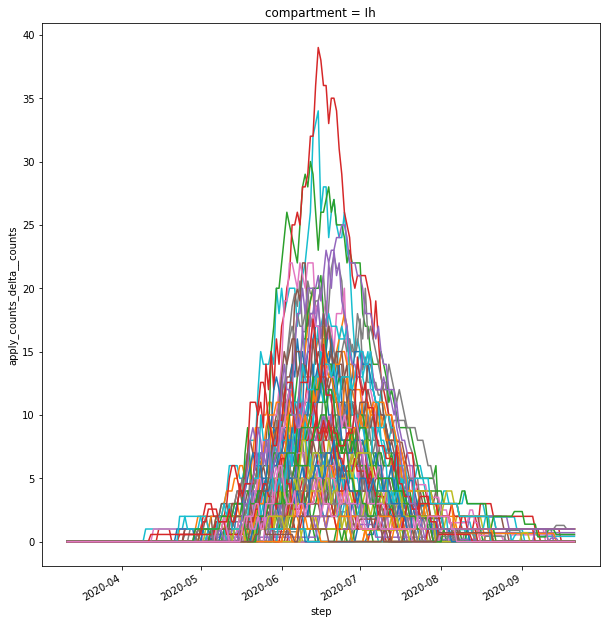

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
demo_arr_all_risk.plot(
    hue='vertex',
    x='step'
)
ax.get_legend().remove()
plt.show()

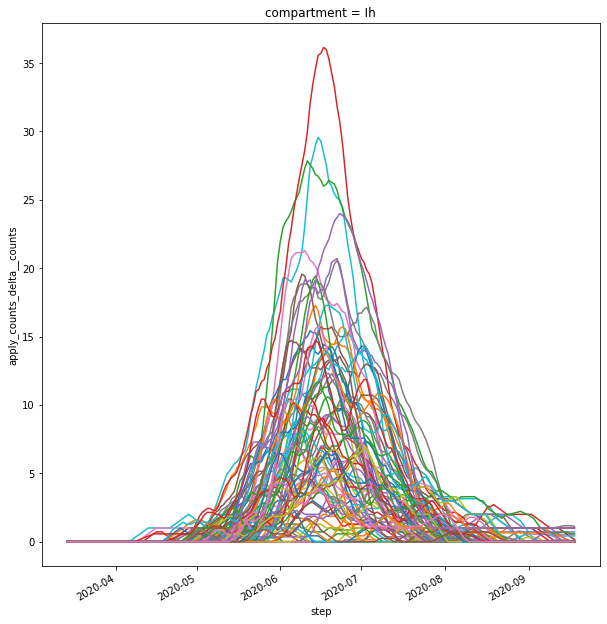

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
demo_arr_all_risk.rolling(
    step=7,
    center=True
).mean().plot(
    hue='vertex',
    x='step'
)
ax.get_legend().remove()
plt.show()

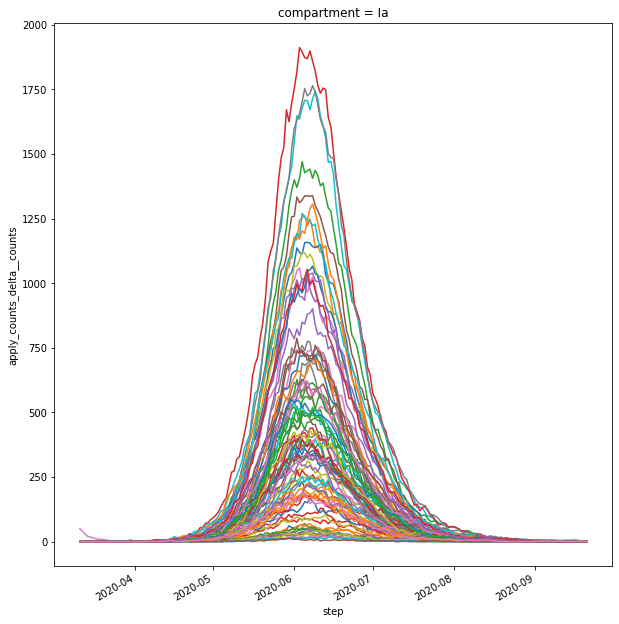

In [12]:
demo_arr_inf = data_arr.sel({'compartment': 'Ia'}).sum(dim=['risk_group', 'age_group'])
fig, ax = plt.subplots(1, 1, figsize=(10,10))
demo_arr_inf.plot(
    hue='vertex',
    x='step'
)
ax.get_legend().remove()
plt.show()

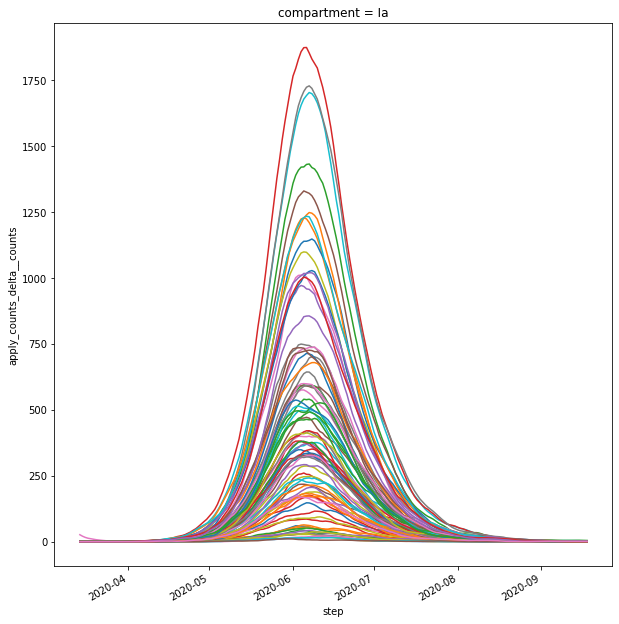

In [13]:
demo_arr_inf = data_arr.sel({'compartment': 'Ia'}).sum(dim=['risk_group', 'age_group'])
fig, ax = plt.subplots(1, 1, figsize=(10,10))
demo_arr_inf.rolling(
    step=7,
    center=True
).mean().plot(
    hue='vertex',
    x='step'
)
ax.get_legend().remove()
plt.show()

In [16]:
peak_dates = demo_arr_inf['step'][demo_arr_inf.argmax(dim='step')]

In [24]:
demo_arr_inf.idxmax(dim='step')

<xarray.DataArray 'step' (vertex: 87)>
dask.array<where, shape=(87,), dtype=datetime64[ns], chunksize=(44,), chunktype=numpy.ndarray>
Coordinates:
    compartment  <U2 'Ia'
  * vertex       (vertex) float64 7.651e+04 7.653e+04 ... 7.895e+04 7.896e+04

In [54]:
demo_arr_inf.argmax('step')

<xarray.DataArray 'apply_counts_delta__counts' (vertex: 87)>
dask.array<nanarg_agg-aggregate, shape=(87,), dtype=int64, chunksize=(44,), chunktype=numpy.ndarray>
Coordinates:
    compartment  <U2 'Ia'
  * vertex       (vertex) float64 7.651e+04 7.653e+04 ... 7.895e+04 7.896e+04

In [69]:
demo_arr_inf.isel(dict(step=demo_arr_inf.argmax('step').values)).isel(dict())

compartment  apply_counts_delta__counts
step       vertex                                         
2020-06-05 76511.0          Ia                   69.500000
           76527.0          Ia                   61.240000
           76530.0          Ia                   46.490000
           76537.0          Ia                  104.070000
           76574.0          Ia                  368.090000
...                        ...                         ...
2020-06-04 78757.0          Ia                  500.240000
           78758.0          Ia                  973.280001
           78759.0          Ia                  849.020000
           78953.0          Ia                    6.900000
           78957.0          Ia                  189.900000

[7569 rows x 2 columns]

Along the step dimension, what is the index of the maximum value in `apply_counts_delta__counts`?

In [92]:
from collections import defaultdict

In [110]:
def peak_timings(da):
    
    vertices = da['vertex'].values
    timing_dict = {'vertex': [], 'step': [], 'apply_counts_delta__counts': []}
    for i in vertices:
        timing_dict['vertex'].append(str(int(i)))
        timing_dict['step'].append(pd.to_datetime(da.sel(dict(vertex=i)).idxmax('step').values.item()))
        timing_dict['apply_counts_delta__counts'].append(da.sel(dict(vertex=i)).max('step').values.item())
    timing_dict_df = pd.DataFrame.from_dict(timing_dict)
    return timing_dict_df

In [111]:
peak_inf = peak_timings(demo_arr_inf)

In [112]:
peak_inf.head()

,vertex,step,apply_counts_delta__counts
0,76511,2020-06-05,69.500000
1,76527,2020-06-07,69.240000
2,76530,2020-06-06,51.490000
3,76537,2020-06-11,129.400001
4,76574,2020-06-04,400.090000


In [113]:
peak_inf[peak_inf['vertex']=='78712']

,vertex,step,apply_counts_delta__counts
46,78712,2020-03-11,50.0


78712 starts the epidemic with 50 individuals in `Ia`, but never exceeds that.

In [116]:
from matplotlib.cm import viridis

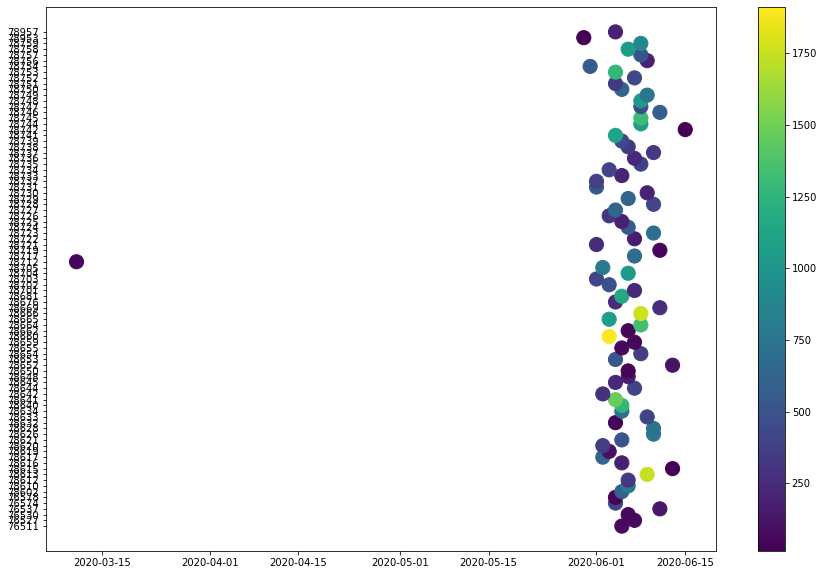

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
plt.scatter(peak_inf['step'], peak_inf['vertex'], c=peak_inf['apply_counts_delta__counts'], cmap=viridis, s=200)
plt.colorbar()
plt.show()

In lieu of a unit test, a sanity check that only 78712 had infections at time 0. (**Note** need to amend `DemoATX.py` to allow specification of an age group and a risk group)

In [118]:
data_arr.sel({'compartment': 'Ia', 'vertex': 78712, 'step': min(data_arr['step'].values)}).values

array([[10.,  0.],
       [10.,  0.],
       [10.,  0.],
       [10.,  0.],
       [10.,  0.]])

In [119]:
data_arr.sel({'compartment': 'Ia', 'vertex': 78751, 'step': min(data_arr['step'].values)}).values

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [120]:
data_arr.sel({'compartment': 'Ia', 'vertex': np.random.choice(data_arr['vertex'].values), 'step': min(data_arr['step'].values)}).values

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [121]:
import geopandas as gpd

DEBUG:shapely.geos:Found GEOS DLL: <CDLL '/Users/kpierce/episimlab/esl-venv/lib/python3.7/site-packages/shapely/.dylibs/libgeos_c.1.dylib', handle 7fcd607ae1d0 at 0x1320ad290>, using it.
DEBUG:fiona.env:GDAL data found in package: path='/Users/kpierce/episimlab/esl-venv/lib/python3.7/site-packages/fiona/gdal_data'.
DEBUG:fiona.env:PROJ data found in package: path='/Users/kpierce/episimlab/esl-venv/lib/python3.7/site-packages/fiona/proj_data'.
DEBUG:fiona.env:Entering env context: <fiona.env.Env object at 0x13233be10>
DEBUG:fiona.env:Starting outermost env
DEBUG:fiona.env:No GDAL environment exists
DEBUG:fiona.env:New GDAL environment <fiona._env.GDALEnv object at 0x13233b9d0> created
DEBUG:fiona._env:GDAL data found in package: path='/Users/kpierce/episimlab/esl-venv/lib/python3.7/site-packages/fiona/gdal_data'.
DEBUG:fiona._env:PROJ data found in package: path='/Users/kpierce/episimlab/esl-venv/lib/python3.7/site-packages/fiona/proj_data'.
DEBUG:fiona._env:Started GDALEnv: self=<fiona

In [122]:
atx_zcta = gpd.read_file('/Users/kpierce/COVID19/austin-spatial-prev/central_tx_zcta_2019.shp')

DEBUG:fiona.env:Entering env context: <fiona.env.Env object at 0x1312cb610>
DEBUG:fiona.env:Starting outermost env
DEBUG:fiona.env:No GDAL environment exists
DEBUG:fiona.env:New GDAL environment <fiona._env.GDALEnv object at 0x13203edd0> created
DEBUG:fiona._env:GDAL data found in package: path='/Users/kpierce/episimlab/esl-venv/lib/python3.7/site-packages/fiona/gdal_data'.
DEBUG:fiona._env:PROJ data found in package: path='/Users/kpierce/episimlab/esl-venv/lib/python3.7/site-packages/fiona/proj_data'.
DEBUG:fiona._env:Started GDALEnv: self=<fiona._env.GDALEnv object at 0x13203edd0>.
DEBUG:fiona.env:Updated existing <fiona._env.GDALEnv object at 0x13203edd0> with options {}
DEBUG:fiona.env:Entered env context: <fiona.env.Env object at 0x1312cb610>
DEBUG:fiona.ogrext:Got coordinate system
DEBUG:fiona.ogrext:OLC_FASTSETNEXTBYINDEX: 1
DEBUG:fiona.ogrext:OLC_FASTFEATURECOUNT: 1
DEBUG:fiona.ogrext:Next index: 0
DEBUG:fiona.ogrext:Next index: 1
DEBUG:fiona.ogrext:Next index: 2
DEBUG:fiona.og

In [123]:
from datetime import datetime

In [128]:
peak_inf['date'] = [int(datetime.strftime(pd.to_datetime(i), '%Y%m%d')) for i in peak_inf['step'].values]


In [129]:
peak_inf.head()

,vertex,step,apply_counts_delta__counts,date
0,76511,2020-06-05,69.500000,20200605
1,76527,2020-06-07,69.240000,20200607
2,76530,2020-06-06,51.490000,20200606
3,76537,2020-06-11,129.400001,20200611
4,76574,2020-06-04,400.090000,20200604


In [131]:
atx_peak = gpd.GeoDataFrame(
    pd.merge(peak_inf, atx_zcta, left_on='vertex', right_on='GEOID10', how='left'),
    crs=atx_zcta.crs
)

In [132]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0.5, 1.0, 'Peak asymptomatic infection date')

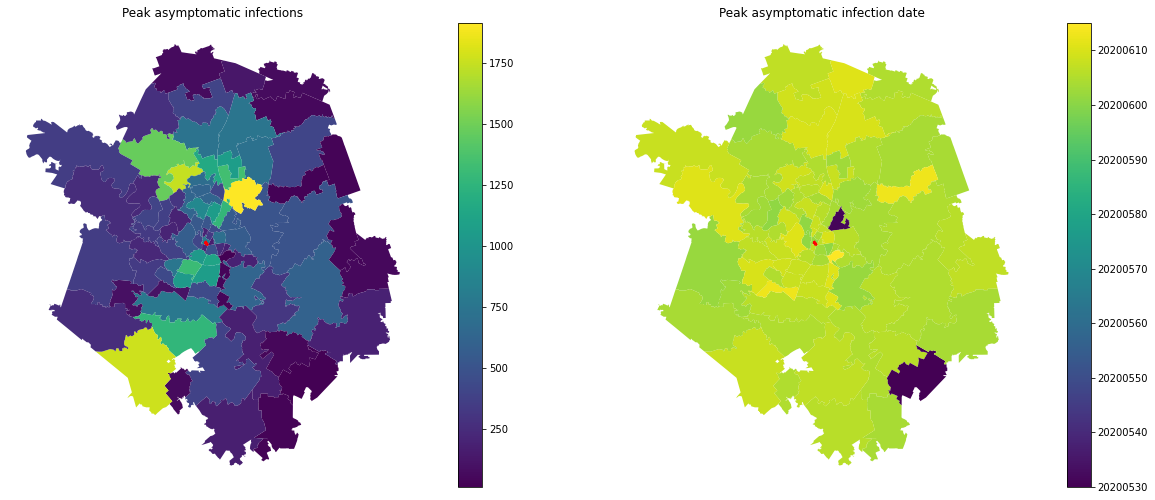

In [134]:
start_zip = atx_zcta[atx_zcta['GEOID10'] == '78712']

fig, ax = plt.subplots(1, 2, figsize=(20,10))
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)

ax[0].set_axis_off()
atx_peak.plot(column='apply_counts_delta__counts', ax=ax[0], legend=True, cax=cax)
start_zip.geometry.boundary.plot(color=None, edgecolor='red', lw=1, ax=ax[0])
ax[0].set_title('Peak asymptomatic infections')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)

ax[1].set_axis_off()
atx_peak_nostart = atx_peak[atx_peak['vertex']!='78712']
atx_peak_nostart.plot(column='date', ax=ax[1], legend=True, cax=cax, legend_kwds={'format': '%.0f'})
start_zip.geometry.boundary.plot(color=None, edgecolor='red', lw=1, ax=ax[1])
ax[1].set_title('Peak asymptomatic infection date')

In [135]:
cumulative_inf = demo_arr_all_inf_inc.sel(dict(step=demo_arr_all_inf_inc['step'][-1]))

In [147]:
cumulative_inf_df = cumulative_inf.to_dataframe().reset_index()
cumulative_inf_df['vertex'] = [str(int(i)) for i in cumulative_inf_df['vertex']]

In [148]:
atx_burden = gpd.GeoDataFrame(
    pd.merge(cumulative_inf_df, atx_zcta, left_on='vertex', right_on='GEOID10', how='left'),
    crs=atx_zcta.crs
)

In [149]:
atx_burden.head()

,vertex,compartment,step,apply_counts_delta__counts,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,76511,Iy2Ih,2020-09-21,4.84,76511,76511,B5,G6350,S,203065394,1122766,+30.8020858,-097.4243625,"POLYGON ((-97.56603 30.77231, -97.56502 30.772..."
1,76527,Iy2Ih,2020-09-21,2.00,76527,76527,B5,G6350,S,332470554,1088225,+30.8417951,-097.8096985,"POLYGON ((-97.93982 30.80608, -97.93973 30.806..."
2,76530,Iy2Ih,2020-09-21,4.00,76530,76530,B5,G6350,S,241943599,13272951,+30.7108572,-097.4138850,"POLYGON ((-97.57607 30.74045, -97.57495 30.740..."
3,76537,Iy2Ih,2020-09-21,9.00,76537,76537,B5,G6350,S,139263240,523639,+30.8174007,-097.6028998,"POLYGON ((-97.68896 30.81950, -97.68550 30.820..."
4,76574,Iy2Ih,2020-09-21,34.00,76574,76574,B5,G6350,S,368793648,8384387,+30.5793270,-097.3886221,"POLYGON ((-97.50380 30.59862, -97.50058 30.599..."


Text(0.5, 1.0, 'Cumulative infections')

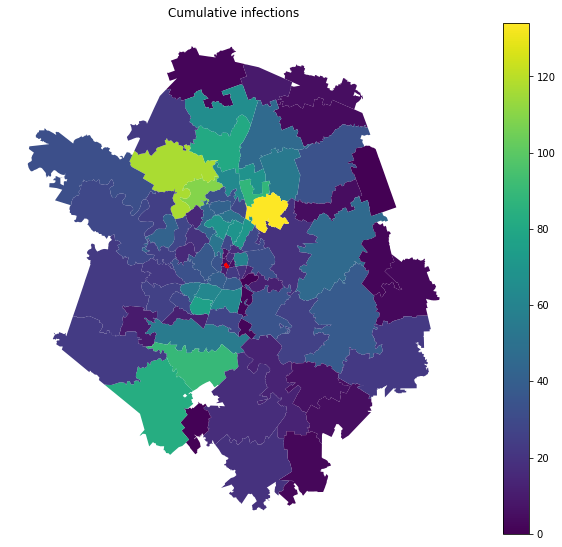

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax.set_axis_off()
atx_burden.plot(column='apply_counts_delta__counts', ax=ax, legend=True, cax=cax, legend_kwds={'format': '%.0f'})
start_zip.geometry.boundary.plot(color=None, edgecolor='red', lw=1, ax=ax)
ax.set_title('Cumulative infections')

In [151]:
census = pd.read_csv('/Users/kpierce/episimlab/data/data_lccf/census_pop1_rows1.csv', dtype={'GEOID': str})
census_zip = census.groupby('GEOID').sum('group_pop').reset_index().drop('Unnamed: 0', axis=1)

In [152]:
census_zip.head()

,GEOID,group_pop
0,75001,14992
1,75002,71253
2,75006,51642
3,75007,55500
4,75009,14089


In [155]:
atx_burden_full_pop = gpd.GeoDataFrame(
    pd.merge(atx_burden, census_zip, left_on='GEOID10', right_on='GEOID', how='left'),
    crs=atx_zcta.crs
)

In [157]:
atx_burden_full_pop['hosp_per_10k'] = (atx_burden_full_pop['apply_counts_delta__counts'] / atx_burden_full_pop['group_pop']) * 10000


In [158]:
atx_burden_full_pop.tail()

,vertex,compartment,step,apply_counts_delta__counts,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,GEOID,group_pop,hosp_per_10k
82,78757,Iy2Ih,2020-09-21,29.00,78757,78757,B5,G6350,S,12732623,0,+30.3515373,-097.7325699,"POLYGON ((-97.75450 30.33742, -97.75439 30.337...",78757,25706,11.281413
83,78758,Iy2Ih,2020-09-21,69.57,78758,78758,B5,G6350,S,24052440,0,+30.3879866,-097.7068484,"POLYGON ((-97.74104 30.37216, -97.74097 30.372...",78758,48993,14.199988
84,78759,Iy2Ih,2020-09-21,69.00,78759,78759,B5,G6350,S,36043140,0,+30.4026666,-097.7610375,"POLYGON ((-97.81147 30.40549, -97.81081 30.406...",78759,43298,15.936071
85,78953,Iy2Ih,2020-09-21,5.12,78953,78953,B5,G6350,S,237066545,536865,+29.8440284,-097.3582969,"POLYGON ((-97.46427 29.84670, -97.46427 29.847...",78953,701,73.038515
86,78957,Iy2Ih,2020-09-21,22.00,78957,78957,B5,G6350,S,484832784,5379587,+30.0138972,-097.1821236,"POLYGON ((-97.35373 29.96039, -97.35371 29.960...",78957,9699,22.682751


Text(0.5, 1.0, 'Cumulative hospitalizations per 10,000 people')

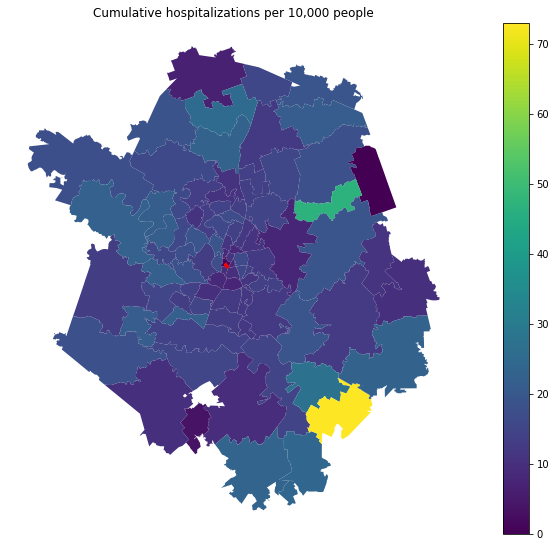

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax.set_axis_off()
atx_burden_full_pop.plot(column='hosp_per_10k', ax=ax, legend=True, cax=cax, legend_kwds={'format': '%.0f'})
start_zip.geometry.boundary.plot(color=None, edgecolor='red', lw=1, ax=ax)
ax.set_title('Cumulative hospitalizations per 10,000 people')

# Decision support vis ideas

... to prototype in a different notebook

- for hospital capacity planning: timing of peak hospitalizations by ZCTA as horizontal boxplots generated by some number of simulations. x axis = time, y axis = ZCTA (categorial axis) 

- for general public health capacity planning (e.g. tests, contact tracing staff, public awareness campaigns): timing of peak infections using the same design as above (**NOTE**: we only provided hospital decision support because we fit to hospitalization data; we should be skeptical of infection peak results that are not fit to infection data)

# Decision making considerations

- what scale of analysis and/or visualization best informs decision making? (e.g. city council districts?)
- who should care about analytic findings? (who is the audience)
- who is accountable for taking action?
- analytic questions should be mutually beneficial to researchers and stakeholders (some research questions produce answers that can do harm in communities through stigma or misinterpretation)

# Equity-driven approaches to parameterizing the model

- Can we use ZCTA-based labor composition to better understand contact patterns? 
    - Assume that work-related contacts are hard to modify, particularly for certain job categories.
    - ZCTAs can be stratified by work/home and labor type, and that stratification can go into `travel_df` (longer term, add support for flexible axis definitions in contact partitioning and `BruteForceSEIR`)

# Appendix - Data munging

## Rationale for data requirements

The model requires three data files to run:
- "travel dataframe" is derived from safegraph mobility and contains source, destination, date, age, and population (n)
- "contact dataframe" is the the baseline per capita contact probability derived from the Polymod study
- "census dataframe" is the standing population of each ZCTA

The census dataframe is used to initialize the susceptible population sizes at the start of a model run. A small number of infected individuals are pulled out of the specified ZCTA to seed the epidemic (note: this example does not include a "risk group" axis in the census data, so the population is by default "low risk". It looks like a PR to modify `counts.InitCountsFromCensusCSV` will be needed to add ability to parse a risk dimension.

Travel and contact dataframes are used to generate the contact matrix using the `Partition` process in episimlab. Partitioning is done for each time step in the model.

## Load `travel.csv`

In [5]:
tr2020 = pd.read_csv('/Users/kpierce/COVID19/safegraph_mobility/2020_travel_for_contact_partitioning.csv')

In [6]:
tr2020.head()

,Unnamed: 0,source,destination,age,n,date,destination_type
0,0,76511,76511,<5,47.377358,2020-05-30,local
1,1,76511,76511,18-49,638.320755,2020-05-30,local
2,2,76511,76511,5-17,202.754717,2020-05-30,local
3,3,76511,76511,50-64,223.641509,2020-05-30,local
4,4,76511,76511,65+,164.037736,2020-05-30,local


In [114]:
all_zcta = set(tr2020['source'].unique()).union(set(tr2020['destination'].unique()))

In [116]:
names = ["source", "destination", "age", "date"]
multi_ind = pd.MultiIndex.from_product(
    [all_zcta, all_zcta, tr2020['age'].unique(), tr2020['date'].unique()], 
    names=names)
tr2020_full = tr2020.set_index(names).reindex(multi_ind, fill_value=0).reset_index()

In [124]:
start_date = '2020-03-11'
end_date = '2020-09-21'
first_wave = tr2020_full[(tr2020_full['date'] < end_date) & (tr2020_full['date'] >= start_date)]
first_wave.to_csv('/Users/kpierce/episimlab/data/full_first_wave_2020_travel.csv')

## Debugging 3/21/2020

This date causes an assertion error in contact partitioning:

    ~/episimlab/episimlab/partition/partition.py in get_phi(self)
        405         self.phi_t.loc[dict(risk_group1='high', risk_group2='high')] = self.contact_xr
        406         self.phi_t.loc[dict(risk_group1='high', risk_group2='low')] = self.contact_xr
    --> 407         assert not self.phi_t.isnull().any()
        408 
        409     def initialize_misc_coords(self):

    AssertionError: 
    
Problem is fixed above, but retaining these code blocks as notes for identifying problem data.

In [7]:
start_date = '2020-03-11'
end_date = '2020-09-21'
first_wave = tr2020[(tr2020['date'] < end_date) & (tr2020['date'] >= start_date)]

In [8]:
first_wave.to_csv('/Users/kpierce/episimlab/data/first_wave_2020_travel.csv')

In [12]:
debug = tr2020[(tr2020['date'] >= '2020-03-20') & (tr2020['date'] <= '2020-03-23')]
debug.to_csv('/Users/kpierce/episimlab/data/debug_2020_03.csv')

In [24]:
problem_date = debug[debug['date'] == '2020-03-21']
problem_date.to_csv('/Users/kpierce/episimlab/data/debug_20200321_travel.csv')

In [25]:
part = partition.Partition2Contact(
    travel_fp = '/Users/kpierce/episimlab/data/debug_20200321_travel.csv',
    contacts_fp = '/Users/kpierce/episimlab/data/polymod_contacts.csv'
)

In [27]:
part.initialize(
    step_delta=np.timedelta64(24, 'h'),
    step_start=np.datetime64('2020-03-21T00:00:00.000000000'),
    step_end=np.datetime64('2020-03-22T00:00:00.000000000')
)

DEBUG:root:'load_travel_df' took 0.03 seconds
DEBUG:root:step_start: 2020-03-21T00:00:00.000000000
DEBUG:root:step_end: 2020-03-21T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 18:18:10.055960


The date in Partition.get_travel_df is ['2020-03-21T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 18:18:17.640700
DEBUG:root:Starting pandas merge 1 at 2021-07-20 18:18:17.641408
DEBUG:root:Starting pandas merge 2 at 2021-07-20 18:18:23.153807
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 18:18:27.330951
DEBUG:root:'dask_partition' took 19.03 seconds
DEBUG:root:Building contact xarray at 2021-07-20 18:18:29.307892


In [28]:
part.run_step(
    step_delta=np.timedelta64(24, 'h'),
    step_start=np.datetime64('2020-03-21T00:00:00.000000000'),
    step_end=np.datetime64('2020-03-22T00:00:00.000000000')
)

DEBUG:root:step_start: 2020-03-21T00:00:00.000000000
DEBUG:root:step_end: 2020-03-22T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 18:18:46.136250


The date in Partition.get_travel_df is ['2020-03-21T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 18:18:53.147912
DEBUG:root:Starting pandas merge 1 at 2021-07-20 18:18:53.148637
DEBUG:root:Starting pandas merge 2 at 2021-07-20 18:18:57.253766
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 18:19:01.391294
DEBUG:root:'dask_partition' took 17.02 seconds
DEBUG:root:Building contact xarray at 2021-07-20 18:19:03.366629


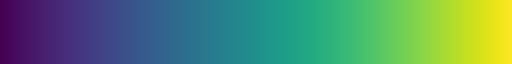

In [85]:
current_cmap

/Users/kpierce/episimlab/esl-venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  This is separate from the ipykernel package so we can avoid doing imports until


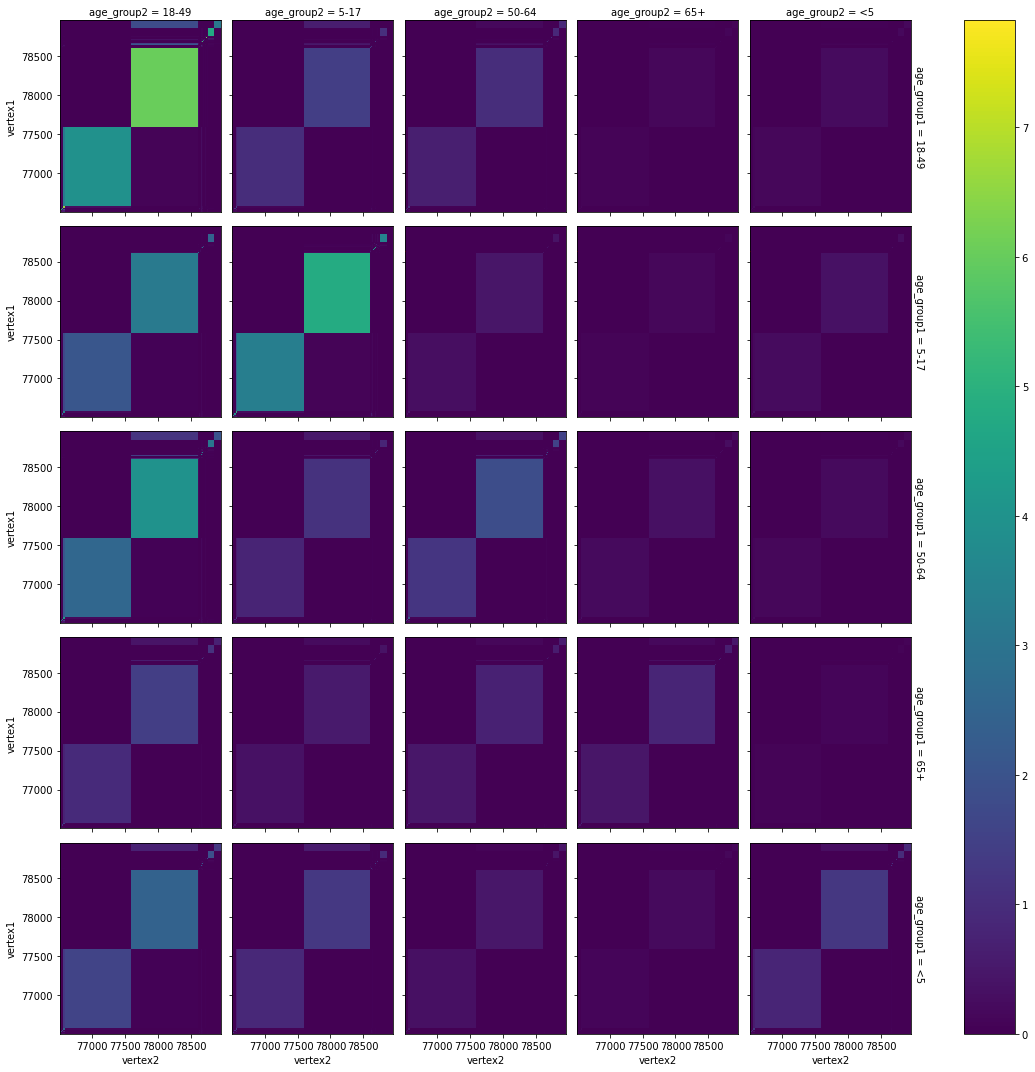

In [86]:
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')
part.contact_xr.plot(row='age_group1', col='age_group2')

In [101]:
np.argwhere(np.isnan(part.contact_xr.values))

array([[ 0, 18,  0,  0],
       [ 0, 18,  0,  1],
       [ 0, 18,  0,  2],
       [ 0, 18,  0,  3],
       [ 0, 18,  0,  4],
       [ 0, 18,  1,  0],
       [ 0, 18,  1,  1],
       [ 0, 18,  1,  2],
       [ 0, 18,  1,  3],
       [ 0, 18,  1,  4],
       [ 0, 18,  2,  0],
       [ 0, 18,  2,  1],
       [ 0, 18,  2,  2],
       [ 0, 18,  2,  3],
       [ 0, 18,  2,  4],
       [ 0, 18,  3,  0],
       [ 0, 18,  3,  1],
       [ 0, 18,  3,  2],
       [ 0, 18,  3,  3],
       [ 0, 18,  3,  4],
       [ 0, 18,  4,  0],
       [ 0, 18,  4,  1],
       [ 0, 18,  4,  2],
       [ 0, 18,  4,  3],
       [ 0, 18,  4,  4],
       [18,  0,  0,  0],
       [18,  0,  0,  1],
       [18,  0,  0,  2],
       [18,  0,  0,  3],
       [18,  0,  0,  4],
       [18,  0,  1,  0],
       [18,  0,  1,  1],
       [18,  0,  1,  2],
       [18,  0,  1,  3],
       [18,  0,  1,  4],
       [18,  0,  2,  0],
       [18,  0,  2,  1],
       [18,  0,  2,  2],
       [18,  0,  2,  3],
       [18,  0,  2,  4],


In [107]:
bad_zip_18 = part.contact_xr['vertex1'][18].values.item()
bad_zip_0 = part.contact_xr['vertex1'][0].values.item()

In [105]:
problem_date.head()

,Unnamed: 0,source,destination,age,n,date,destination_type
3818700,3818700,76511,76511,<5,62.911765,2020-03-21,local
3818701,3818701,76511,76511,18-49,847.617647,2020-03-21,local
3818702,3818702,76511,76511,5-17,269.235294,2020-03-21,local
3818703,3818703,76511,76511,50-64,296.970588,2020-03-21,local
3818704,3818704,76511,76511,65+,217.823529,2020-03-21,local


In [109]:
problem_date[(problem_date['source'] == bad_zip_18) & (problem_date['destination'] == bad_zip_0)]

,Unnamed: 0,source,destination,age,n,date,destination_type


In [110]:
problem_date[(problem_date['source'] == bad_zip_0) & (problem_date['destination'] == bad_zip_18)]

,Unnamed: 0,source,destination,age,n,date,destination_type


Contact partitioning fails because there is no travel between these zip codes on this date.

In [122]:
tr2020_full[
    (tr2020_full['source'] == bad_zip_18) & \
    (tr2020_full['destination'] == bad_zip_0) & \
    (tr2020_full['date'] == '2020-03-21')]

,source,destination,age,date,Unnamed: 0,n,destination_type
2883136,78632,76511,<5,2020-03-21,0,0.0,0
2883467,78632,76511,18-49,2020-03-21,0,0.0,0
2883798,78632,76511,5-17,2020-03-21,0,0.0,0
2884129,78632,76511,50-64,2020-03-21,0,0.0,0
2884460,78632,76511,65+,2020-03-21,0,0.0,0


In [123]:
tr2020_full[
    (tr2020_full['destination'] == bad_zip_18) & \
    (tr2020_full['source'] == bad_zip_0) & \
    (tr2020_full['date'] == '2020-03-21')]

,source,destination,age,date,Unnamed: 0,n,destination_type
321196,76511,78632,<5,2020-03-21,0,0.0,0
321527,76511,78632,18-49,2020-03-21,0,0.0,0
321858,76511,78632,5-17,2020-03-21,0,0.0,0
322189,76511,78632,50-64,2020-03-21,0,0.0,0
322520,76511,78632,65+,2020-03-21,0,0.0,0


# Load `contact.csv`

In [6]:
polymod = pd.read_csv('/Users/kpierce/episimlab/data/polymod_contacts.csv')

In [7]:
polymod

,Unnamed: 0,age1,age2,daily_per_capita_contacts
0,0,<5,<5,2.160941
1,1,5-17,<5,0.597341
2,2,18-49,<5,0.382203
3,3,50-64,<5,0.352397
4,4,65+,<5,0.189756


# Load `census.csv`

In [16]:
census = pd.read_csv('/Users/kpierce/episimlab/data/data_lccf/census_pop1_rows1.csv')

In [17]:
census.head()

,Unnamed: 0,GEOID,NAME,age_bin,group_pop
0,1,75001,ZCTA5 75001,<5,794
1,2,75001,ZCTA5 75001,18-49,9420
2,3,75001,ZCTA5 75001,5-17,1404
3,4,75001,ZCTA5 75001,50-64,2259
4,5,75001,ZCTA5 75001,65+,1115


In [18]:
census[census['GEOID'] == 78712]

,Unnamed: 0,GEOID,NAME,age_bin,group_pop
7590,7591,78712,ZCTA5 78712,<5,0
7591,7592,78712,ZCTA5 78712,18-49,871
7592,7593,78712,ZCTA5 78712,5-17,9
7593,7594,78712,ZCTA5 78712,50-64,0
7594,7595,78712,ZCTA5 78712,65+,0


In [21]:
first_wave = pd.read_csv('/Users/kpierce/episimlab/data/full_first_wave_2020_travel.csv')

(array([1.0822e+04, 2.2700e+02, 3.5000e+01, 2.2000e+01, 2.2000e+01,
        3.1000e+01, 4.3000e+01, 3.2000e+01, 9.0000e+00, 9.0000e+00]),
 array([6.28491620e-03, 6.22607384e+01, 1.24515192e+02, 1.86769645e+02,
        2.49024099e+02, 3.11278552e+02, 3.73533006e+02, 4.35787459e+02,
        4.98041913e+02, 5.60296366e+02, 6.22550820e+02]),
 <BarContainer object of 10 artists>)

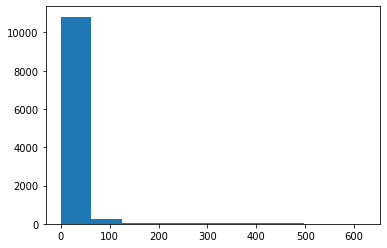

In [23]:
plt.hist(first_wave[(first_wave['source'] == 78712) & (first_wave['n'] > 0)]['n'])